In [51]:
import xgboost as xgb
import pandas as pd
import sqlalchemy
import yahooquery as yq
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import requests
import matplotlib.pyplot as plt
import datetime as dt

In [53]:
engine = sqlalchemy.create_engine('sqlite:///' + "Financial.db", execution_options={"sqlite_raw_colnames": True})
df_financial = pd.read_sql_table('FinancialDataJoined', engine)

engine = sqlalchemy.create_engine('sqlite:///' + "SEC_Filings.db", execution_options={"sqlite_raw_colnames": True})
df_sentiments = pd.read_sql_table('Aggregated_Sentiment_Scores', engine)
df_SIC = pd.read_sql_table("10K_Data", engine)
df_SIC = df_SIC[['SIC', 'CIK']]

agri = ['0100', '0200', '0900']
fin = ['6172', '6199', '6200', '6211', '6221', '6282']
air = ['4513', '4522', '4581']
bank = ['6022', '6029', '6035', '6036', '6099']

df_SIC['Industry'] = ''
df_SIC.loc[df_SIC['SIC'].isin(agri), 'Industry'] = "Agriculture"
df_SIC.loc[df_SIC['SIC'].isin(fin), 'Industry'] = "Financial Services"
df_SIC.loc[df_SIC['SIC'].isin(air), 'Industry'] = "Aviation"
df_SIC.loc[df_SIC['SIC'].isin(bank), 'Industry'] = "Banking"

In [54]:
aspect_counts=df_sentiments[['Industry', 'Aspect', 'Count']].groupby(['Industry', 'Aspect']).sum().values
df_sentiments['Total Sentiment'] = df_sentiments['Count']*df_sentiments['Aggregated Sentiment']

avg_sentiments = df_sentiments[['Industry', 'Aspect', 'Total Sentiment']].groupby(['Industry', 'Aspect']).sum()/aspect_counts
avg_sentiments.reset_index(drop=False, inplace=True)
avg_sentiments.rename(columns={'Total Sentiment': 'Average Sentiment'}, inplace=True)

df_sentiments_avg = df_sentiments.merge(avg_sentiments, on=['Industry', 'Aspect'])
df_sentiments_avg.drop(['Aggregated Sentiment', 'Average Mentions', 'Total Sentiment'], axis=1, inplace=True)

In [55]:
tab = df_SIC.merge(df_sentiments_avg, on="Industry", how="left")

df_pivot = pd.pivot_table(tab, values='Average Sentiment', index=['CIK', 'Year'], 
                          columns=['Aspect'], fill_value=0).reset_index(drop=False)
ind = tab[['CIK', 'Year', 'Industry']].drop_duplicates(ignore_index=True)

df_pivot = ind.merge(df_pivot, on=['CIK', 'Year'])
df_financial['Year'] = df_financial['asOfDate'].dt.year+1
df_pivot_joined = df_pivot.merge(df_financial, on=['CIK', 'Year'])

ticker = df_pivot_joined.pop('Ticker')
company  = df_pivot_joined.pop('Company')

df_pivot_joined.insert(1, 'Company', company)
df_pivot_joined.insert(2, 'Ticker', ticker)
df_pivot_joined.drop(['asOfDate', 'date'], axis=1, inplace=True)

In [57]:
df_stock = pd.DataFrame()

for ticker in df_pivot_joined['Ticker'].unique():
    tick = yq.Ticker(ticker)
    df_stock = pd.concat([df_stock, tick.history(start='01-01-2019', interval='3mo')[0::4]], axis=0)

df_stock = df_stock.pop("adjclose").reset_index(drop=False)
df_stock["Year"] = df_stock["date"].apply(lambda x: x.year)
df_stock.pop("date")

# log return
for ticker in df_stock['symbol'].unique():
    df_stock.loc[df_stock['symbol']==ticker, 'Return'] = np.log(df_stock.loc[df_stock['symbol']==ticker, 'adjclose'].pct_change()+1)

df_stock.dropna(inplace=True)
df_stock.drop('adjclose', axis=1, inplace=True)
df_stock = df_stock.rename(columns={"symbol": "Ticker"})

In [58]:
df_ml_full = df_pivot_joined.merge(df_stock, on=['Ticker', 'Year'])

df_ml_full.drop(["CIK", "Company", "Ticker"], axis=1, inplace=True)
df_ml_full = pd.get_dummies(df_ml_full, drop_first=True)

df_ml_full.dropna(inplace=True)
# Drop outliers which had undue influence over the model output
# Correspond to companies which went 20x or value fell by 95% over course of a year
df_ml_full = df_ml_full.loc[abs(df_ml_full['Return'])<3] 

Return = df_ml_full.pop("Return")
df_ml_full.drop(axis=1, labels=['Year'], inplace=True)

In [59]:
df_ml_full

,algorithm,artificial intelligence,automation,bots,machine learning,BasicEPS,BTM,Gearing,CashToAssets,logMktCap,Industry_Aviation,Industry_Banking,Industry_Financial Services
0,0.319512,0.000000,0.309676,0.000000,0.000000,1.91,0.644012,0.000108,0.077450,18.965636,0,1,0
1,0.319512,0.585402,0.309676,0.292425,0.000000,1.70,0.739600,0.000052,0.069589,18.954042,0,1,0
2,0.319512,0.585402,0.309676,0.292425,0.657992,2.40,0.520391,0.000042,0.126535,19.436657,0,1,0
3,0.319512,0.585402,0.309676,0.000000,0.657992,0.00,0.415587,0.000035,0.117596,19.757168,0,1,0
4,0.319512,0.000000,0.309676,0.000000,0.000000,2.46,0.856992,0.064933,0.040148,20.107702,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,0.000000,0.496900,0.309323,0.000000,0.000000,-0.32,1.698842,0.041039,0.387220,18.649532,0,0,0
1501,0.000000,0.496900,0.309323,0.000000,0.000000,0.00,2.304134,0.041510,0.475300,18.236752,0,0,0
1502,0.000000,0.496900,0.309323,0.000000,0.000000,-0.01,0.009387,0.533187,0.010238,19.633952,0,0,0
1503,0.000000,0.496900,0.309323,0.000000,0.000000,-0.16,-0.341639,0.096214,0.045755,18.801838,0,0,0


In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    df_ml_full, Return, test_size=0.3, random_state=20
)

In [61]:
model_xgb = xgb.XGBRegressor()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'max_depth': [3, 5, 10, 20],
    'n_estimators': [10, 50, 100, 250],
    'colsample_bytree': [0.75, 1]
}

grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, scoring='explained_variance', cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.3f}")

Best parameters: {'colsample_bytree': 0.75, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
Best score: 0.293


In [1]:
plt.scatter(y_test, grid_search.predict(X_test), alpha=0.2)

NameError: name 'plt' is not defined

In [63]:
np.mean((y_test-grid_search.predict(X_test))**2)

0.18809293137163127

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

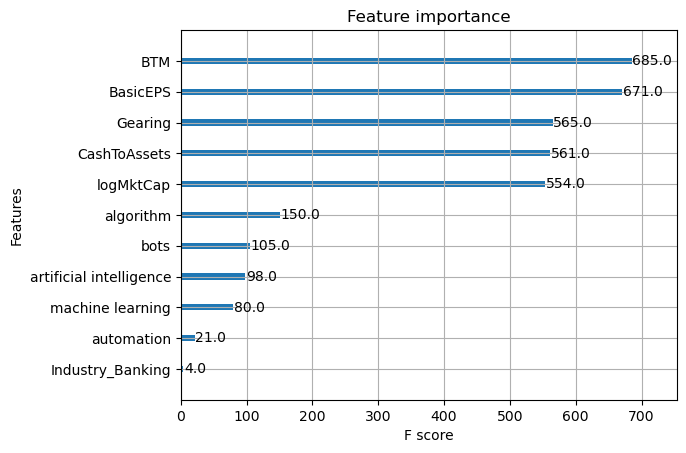

In [64]:
model_xgb = xgb.XGBRegressor(kwargs=grid_search.best_params_)
model_xgb.fit(X_train, y_train)

xgb.plot_importance(model_xgb, importance_type='weight')

In [65]:
RF = RandomForestRegressor()

paramgrid = {
             'n_estimators': [20, 100, 150, 250, 300, 500],
             'criterion': ['squared_error', 'absolute_error'],
             'max_features': ['sqrt', 'log2'],
             'max_depth': [3, 5, 10, 15, 25],
             }

G_CV = GridSearchCV(RF, param_grid=paramgrid, scoring='explained_variance', n_jobs=-1, cv=5)
G_CV.fit(X_train, y_train)
print(f"Best parameters: {G_CV.best_params_}")
print(f"Best Score: {G_CV.best_score_}")

c:\Users\Gavin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(


Best parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}
Best Score: 0.35479709152646965


c:\Users\Gavin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(


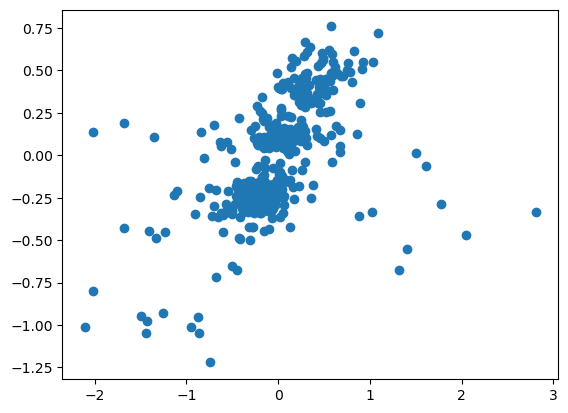

In [66]:
plt.scatter(y_test, G_CV.predict(X_test))